In [0]:
import torch
import torchvision
import numpy as np 
import random
import matplotlib.pyplot as plt
import time

In [0]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

In [3]:
CIFAR_train = torchvision.datasets.CIFAR10('/', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('/', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
type(CIFAR_train.data)

numpy.ndarray

In [0]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)

X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [6]:
X_train.shape, X_test.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([10000, 32, 32, 3]))

In [7]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [0]:
X_train /= 255.
X_test /= 255.

In [9]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

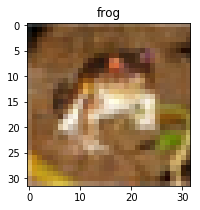

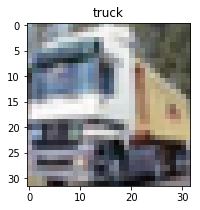

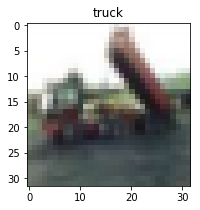

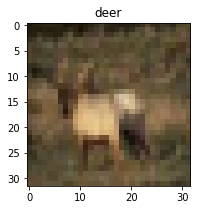

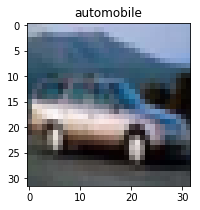

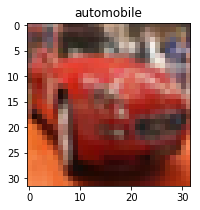

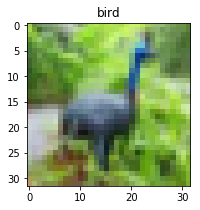

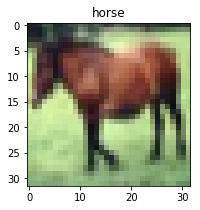

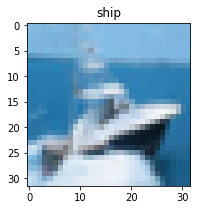

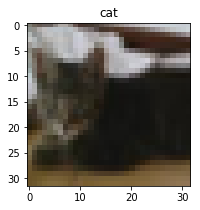

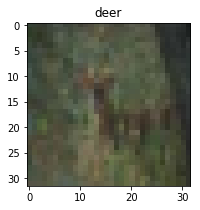

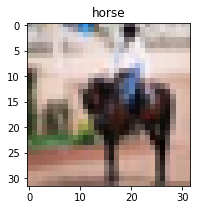

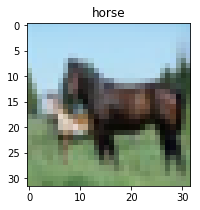

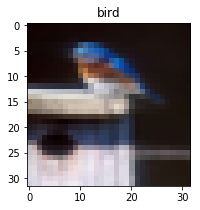

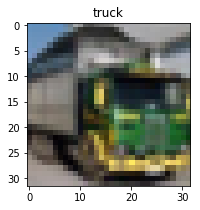

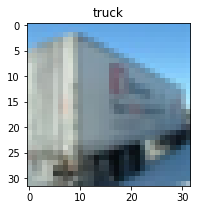

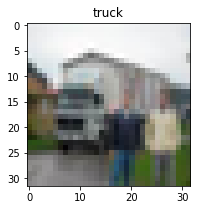

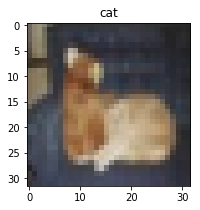

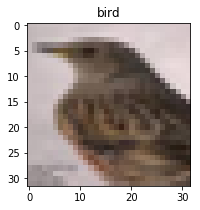

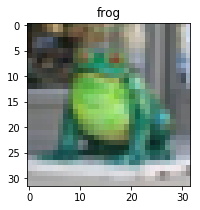

In [10]:
for i in range(20):
  plt.figure(figsize=(3, 3))
  plt.imshow(X_train[i])
  plt.title(CIFAR_train.classes[y_train[i]])

In [11]:
X_train.shape, X_test.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([10000, 32, 32, 3]))

In [0]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [13]:
X_train.shape, X_test.shape

(torch.Size([50000, 3, 32, 32]), torch.Size([10000, 3, 32, 32]))

In [0]:
class LambdaLayer(torch.nn.Module):
  def __init__(self, lambd):
    super().__init__()
    self.lambd = lambd
    
  def forward(self, x):
    return self.lambd(x)

In [0]:
class BasicBlock(torch.nn.Module):
  expansion = 1
  
  def __init__(self, 
               in_channels, 
               out_channels, 
               stride=1, 
               use_batch_norm=True,
               use_dropout=False,
               dropout_prob=0.2,
               option='A'):
    super().__init__()
    self.use_batch_norm = use_batch_norm
    self.use_dropout = use_dropout
    self.dropout_prob = dropout_prob
    
    self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 
                                 kernel_size=3, stride=stride,
                                 padding=1, bias=False)
    self.bn1 = torch.nn.BatchNorm2d(out_channels)
    self.dropout1 = torch.nn.Dropout2d(self.dropout_prob)
    
    self.conv2 = torch.nn.Conv2d(out_channels, out_channels,
                                 kernel_size=3, stride=1,
                                 padding=1, bias=False)
    self.bn2 = torch.nn.BatchNorm2d(out_channels)
    self.dropout2 = torch.nn.Dropout2d(self.dropout_prob)
    
    self.shortcut = torch.nn.Sequential()
    
    if stride != 1 or in_channels != out_channels:
      
      if option == 'A':
        self.shortcut = LambdaLayer(
            lambda x: torch.nn.functional.pad(
                x[:, :, ::2, ::2], 
                (0, 0, 0, 0, out_channels//4, out_channels//4), 
                'constant', 0)
                                   )
        
        
      elif option == 'B':
        self.shortcut = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, self.expansion * out_channels, 
                            kernel_size=1, stride=stride, bias=False), 
            torch.nn.BatchNorm2d(self.expansion * out_channels))
  
  def forward(self, x):
    out = self.conv1(x)
    if self.use_batch_norm:
      out = self.bn1(out)
    if self.use_dropout:
      out = self.dropout1(out)
    out = torch.nn.functional.relu(out)
      
    out = self.conv2(out)
    if self.use_batch_norm:
      out = self.bn2(out)
    if self.use_dropout:
      out = self.dropout2(out)
      
    out += self.shortcut(x)  
    out = torch.nn.functional.relu(out)
    
    return out
    

In [0]:
def _weights_init(model):
  classname = model.__class__.__name__
  
  if isinstance(model, torch.nn.Linear) or isinstance(model, torch.nn.Conv2d):
    torch.nn.init.kaiming_normal_(model.weight)

In [0]:
class ResNet(torch.nn.Module):
  def __init__(self,
               basic_block,
               list_num_blocks,
               use_batch_norm=True,
               use_dropout=False,
               dropout_prob=0.2,
               num_classes=10):
    super().__init__()
    self.use_batch_norm = use_batch_norm
    self.use_dropout = use_dropout
    self.dropout_prob = dropout_prob
    
    self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, 
                                 stride=1, padding=1, bias=False)
    self.bn1 = torch.nn.BatchNorm2d(16)
    self.dropout1 = torch.nn.Dropout2d(self.dropout_prob)
    
    self.in_channels = 16
    self.layer1 = self._make_layer(basic_block, 16, list_num_blocks[0], stride=1)
    self.layer2 = self._make_layer(basic_block, 32, list_num_blocks[1], stride=2)
    self.layer3 = self._make_layer(basic_block, 64, list_num_blocks[2], stride=2)
    
    self.fc1 = torch.nn.Linear(64, num_classes)
    
    self.apply(_weights_init)
    
  def _make_layer(self, basic_block, out_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    
    for stride in strides:
      layers.append(basic_block(self.in_channels, 
                                out_channels, stride,
                                use_batch_norm=self.use_batch_norm,
                                use_dropout=self.use_dropout,
                                dropout_prob=self.dropout_prob))
      
      self.in_channels = out_channels * basic_block.expansion
      
    return torch.nn.Sequential(*layers)
  
  def forward(self, x):
    out = self.conv1(x)
    if self.use_batch_norm:
      out = self.bn1(out)
    if self.use_dropout:
      out = self.dropout1(out)
    
    out = torch.nn.functional.relu(out)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = torch.nn.functional.avg_pool2d(out, out.size()[3])
    
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    
    return out
      
    
    

In [0]:
def resnet20(use_batch_norm=True, use_dropout=False, dropout_prob=0.2):
  return ResNet(BasicBlock, [3, 3, 3], 
                use_batch_norm=use_batch_norm, 
                use_dropout=use_dropout,
                dropout_prob=dropout_prob)

def resnet110(use_batch_norm=True, use_dropout=False, dropout_prob=0.2):
  return ResNet(BasicBlock, [16, 20, 18],
                use_batch_norm=use_batch_norm, 
                use_dropout=use_dropout,
                dropout_prob=dropout_prob)


In [0]:
def train(net, X_train, y_train, X_test, y_test):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print(device)
  net = net.to(device)
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
  
  batch_size = 100
  
  test_accuracy_history = []
  test_loss_history = []
  
  t = time.time()
  
#   X_test = X_test.to(device)
#   y_test = y_test.to(device)
  
  for epoch in range(30):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()
      net.train()
      
      batch_indicies = order[start_index: start_index+batch_size]
      
      X_batch = X_train[batch_indicies].to(device)
      y_batch = y_train[batch_indicies].to(device)
      
      y_pred = net.forward(X_batch)
      
      loss_value = loss(y_pred, y_batch)
      loss_value.backward()
      
      optimizer.step()
      
    net.eval()
    with torch.no_grad():
      test_preds = net.forward(X_test.to(device))
      loss_val = loss(test_preds, y_test.to(device)).data.cpu()
      test_loss_history.append(loss_val)

      accuracy = (test_preds.argmax(dim=1) == y_test.to(device)).float().mean().data.cpu()
      test_accuracy_history.append(accuracy)
      
      time_epoch = time.strftime("%H:%M:%S", time.gmtime(time.time() - t))
      print('epoch:', epoch, ',', 'time:', time_epoch, ',', 
            'accuracy:', accuracy, 'loss:', loss_val)
    
  print('learning is over')
  return test_accuracy_history, test_loss_history

In [0]:
accuracies, losses = {}, {}

resnet18 = torchvision.models.resnet18()

accuracies['resnet18'], losses['resnet18'] = train(resnet18, 
                                                   X_train, y_train,
                                                   X_test, y_test)

accuracies['resnet20_drop_0.2'], losses['resnet20_drop_0.2'] = train(resnet20(use_batch_norm=False, 
                                                                              use_dropout=True,
                                                                              dropout_prob=0.2),
                                                                     X_train, y_train,
                                                                     X_test, y_test)

accuracies['resnet20_drop_0.4'], losses['resnet20_drop_0.4'] = train(resnet20(use_batch_norm=False, 
                                                                              use_dropout=True, 
                                                                              dropout_prob=0.4),
                                                                     X_train, y_train,
                                                                     X_test, y_test)


accuracies['resnet20_bn_drop_0.2'], losses['resnet20_bn_drop_0.2'] = train(resnet20(use_batch_norm=True,
                                                                                    use_dropout=True, 
                                                                                    dropout_prob=0.2),
                                                                           X_train, y_train,
                                                                           X_test, y_test)

accuracies['resnet110_no_bn'], losses['resnet110_no_bn'] = train(resnet110(use_batch_norm=False, 
                                                                           use_dropout=False, 
                                                                           dropout_prob=0.2),
                                                                 X_train, y_train,
                                                                 X_test, y_test)

accuracies['resnet110_bn_drop_0.2'], losses['resnet110_bn_drop_0.2'] = train(resnet110(use_batch_norm=True, 
                                                                                       use_dropout=True, 
                                                                                       dropout_prob=0.2),
                                                                             X_train, y_train,
                                                                             X_test, y_test)

cuda:0
epoch: 0 , time: 00:00:39 , accuracy: tensor(0.5645) loss: tensor(1.2119)
epoch: 1 , time: 00:01:19 , accuracy: tensor(0.6580) loss: tensor(0.9822)
epoch: 2 , time: 00:01:58 , accuracy: tensor(0.6328) loss: tensor(1.0732)
epoch: 3 , time: 00:02:38 , accuracy: tensor(0.6961) loss: tensor(0.8809)
epoch: 4 , time: 00:03:17 , accuracy: tensor(0.7128) loss: tensor(0.8318)
epoch: 5 , time: 00:03:57 , accuracy: tensor(0.7052) loss: tensor(0.9034)
epoch: 6 , time: 00:04:37 , accuracy: tensor(0.7354) loss: tensor(0.8545)
epoch: 7 , time: 00:05:16 , accuracy: tensor(0.7470) loss: tensor(0.8359)
epoch: 8 , time: 00:05:56 , accuracy: tensor(0.7191) loss: tensor(0.9910)
epoch: 9 , time: 00:06:35 , accuracy: tensor(0.7551) loss: tensor(0.9097)
epoch: 10 , time: 00:07:15 , accuracy: tensor(0.7455) loss: tensor(0.9855)
epoch: 11 , time: 00:07:54 , accuracy: tensor(0.7452) loss: tensor(0.9932)
epoch: 12 , time: 00:08:34 , accuracy: tensor(0.7488) loss: tensor(1.0414)
epoch: 13 , time: 00:09:13 ,

In [0]:
def exp_plotter(data, name):
  plt.figure(figsize=(10, 6))
  for exp_id in data.keys():
    plt.plot(data[exp_id], label=exp_id)
  plt.legend()
  plt.title(str(name))

In [2]:
exp_plotter(accuracies, 'accuracies')
exp_plotter(losses, 'losses')

NameError: ignored